# Semantic Chunking
In this notebook I will try an semantic chunking startegy developed by Greg. [Link](https://github.com/FullStackRetrieval-com/RetrievalTutorials/blob/8a30b5710b3dd99ef2239fb60c7b54bc38d3613d/tutorials/LevelsOfTextSplitting/5_Levels_Of_Text_Splitting.ipynb)

In [4]:
with open('../fiqa_dataset/corpus.txt') as file:
    corpus = file.read()


In [5]:
import re

single_sentences_list = re.split(r'(?<=[.?!])\s+', corpus)
print (f"{len(single_sentences_list)} sentences were found")



399187 sentences were found


In [6]:
small_single_sentences_list = single_sentences_list[:1000]

sentences = [{'sentence': x, 'index': i} for i, x in enumerate(small_single_sentences_list)]
sentences[:3]


1000 sentences were found


[{'sentence': "I'm not saying I don't like the idea of on-the-job training too, but you can't expect the company to do that.",
  'index': 0},
 {'sentence': "Training workers is not their job - they're building software.",
  'index': 1},
 {'sentence': 'Perhaps educational systems in the U.S.', 'index': 2}]

Create dictionary to store additional information later

In [15]:
sentences = [{'sentence': x, 'index' : i} for i, x in enumerate(single_sentences_list)]
sentences[:3]

[{'sentence': "I'm not saying I don't like the idea of on-the-job training too, but you can't expect the company to do that.",
  'index': 0},
 {'sentence': "Training workers is not their job - they're building software.",
  'index': 1},
 {'sentence': 'Perhaps educational systems in the U.S.', 'index': 2}]

Now we want to combine the senteces with the one before and after. Therefor we use butter_size=1

In [7]:
def combine_sentences(sentences, buffer_size=1):
    # Go through each sentence dict
    for i in range(len(sentences)):

        # Create a string that will hold the sentences which are joined
        combined_sentence = ''

        # Add sentences before the current one, based on the buffer size.
        for j in range(i - buffer_size, i):
            # Check if the index j is not negative (to avoid index out of range like on the first one)
            if j >= 0:
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += sentences[j]['sentence'] + ' '

        # Add the current sentence
        combined_sentence += sentences[i]['sentence']

        # Add sentences after the current one, based on the buffer size
        for j in range(i + 1, i + 1 + buffer_size):
            # Check if the index j is within the range of the sentences list
            if j < len(sentences):
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += ' ' + sentences[j]['sentence']

        # Then add the whole thing to your dict
        # Store the combined sentence in the current sentence dict
        sentences[i]['combined_sentence'] = combined_sentence

    return sentences

sentences = combine_sentences(sentences)

In [8]:
sentences[:3]

[{'sentence': "I'm not saying I don't like the idea of on-the-job training too, but you can't expect the company to do that.",
  'index': 0,
  'combined_sentence': "I'm not saying I don't like the idea of on-the-job training too, but you can't expect the company to do that. Training workers is not their job - they're building software."},
 {'sentence': "Training workers is not their job - they're building software.",
  'index': 1,
  'combined_sentence': "I'm not saying I don't like the idea of on-the-job training too, but you can't expect the company to do that. Training workers is not their job - they're building software. Perhaps educational systems in the U.S."},
 {'sentence': 'Perhaps educational systems in the U.S.',
  'index': 2,
  'combined_sentence': "Training workers is not their job - they're building software. Perhaps educational systems in the U.S. (or their students) should worry a little about getting marketable skills in exchange for their massive investment in education

We want to create embeddings for each batch (3 sentences) and add them to the corresponding dictionary index.

In [9]:
from langchain_openai import OpenAIEmbeddings
import os

oaiembeds = OpenAIEmbeddings(model='text-embedding-3-small', api_key=os.environ.get('OPENAI_API_KEY'))

embeddings = oaiembeds.embed_documents([x['combined_sentence'] for x in sentences])

for i, sentence in enumerate(sentences):
    sentence['combined_sentence_embedding'] = embeddings[i]

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_distances(sentences):
    distances = []
    for i in range(len(sentences) - 1):
        embedding_current = sentences[i]['combined_sentence_embedding']
        embedding_next = sentences[i + 1]['combined_sentence_embedding']
        
        # Calculate cosine similarity
        similarity = cosine_similarity([embedding_current], [embedding_next])[0][0]
        
        # Convert to cosine distance
        distance = 1 - similarity

        # Append cosine distance to the list
        distances.append(distance)

        # Store distance in the dictionary
        sentences[i]['distance_to_next'] = distance

    # Optionally handle the last sentence
    # sentences[-1]['distance_to_next'] = None  # or a default value

    return distances, sentences

distances, sentences = calculate_cosine_distances(sentences)

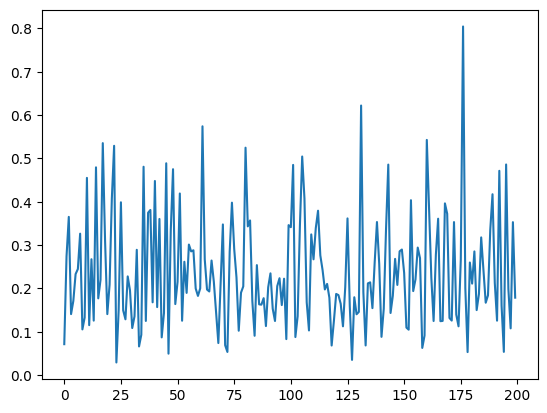

In [14]:
import matplotlib.pyplot as plt

plt.plot(distances[0:200])

## SemanticChunker by LangChain ([link](https://python.langchain.com/v0.2/docs/how_to/semantic-chunker/))

from langchain_experimental.text_splitter import SemanticChunker

Unfortunately, I was not able to use this text splitter on the fiqa corpus because my device is running out of RAM. Therefore I have created a script "semantic_chunker.py" with is incrementally splitting the text.

### View semantic chunks
I was able to perform semantic chunking on the "rechenknecht". Therefore I process a batch of 1000 sentences and store the recognized chunks within the 1000 sentences in the chroma vectorstore. All sentences processed in 4611.23 sec (77 min)

In [1]:
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from dotenv import load_dotenv
import pandas as pd

load_dotenv()

vectorstore = Chroma(persist_directory = "../vectorstores/percentile", embedding_function=OpenAIEmbeddings(model='text-embedding-3-small'))

chunks = vectorstore.get()

df = pd.DataFrame(chunks)
print(df)

first_chunk_text = df.loc[0, 'documents'] if 'documents' in df.columns else None
print("First chunk text:", first_chunk_text)

                                        ids embeddings metadatas  \
0      0005b856-05a0-4590-bb34-a2b9d9be476f       None      None   
1      0005f734-bd7e-480b-9428-13abfade7e92       None      None   
2      00102bcf-b922-4fe5-8c47-ec5db3fa582c       None      None   
3      00143509-825f-4eb6-8d5e-b60b135b5ad3       None      None   
4      00195f75-82be-45a2-be64-6f8cfbf099dc       None      None   
...                                     ...        ...       ...   
20355  ffe82096-74dc-439d-96df-ab2818703335       None      None   
20356  ffee0697-563d-4639-898c-0c5cba4f9746       None      None   
20357  fff7a448-6fec-4af4-98b0-5177fc78b08b       None      None   
20358  fff8c758-a810-4857-aa1f-36f805340b12       None      None   
20359  fffda997-e44e-4bd7-a057-9f5818c28d7a       None      None   

                                               documents  uris  data  
0      Just had to throw your primary assertion back ...  None  None  
1      It's been that way for 50 years. I

Show distribution of chunk lengths

Number of Chunks 20360
Lengths of Chunks [1738, 308, 553, 1265, 1283, 125, 1131, 9307, 324, 5178, 11259, 6382, 1072, 272, 1531, 518, 18309, 1761, 1002, 796, 270, 524, 1219, 1497, 2658, 2730, 2832, 3452, 281, 686, 21, 3097, 2968, 6860, 568, 4304, 814, 4256, 4219, 1835, 3181, 1233, 839, 5477, 3244, 223, 2048, 1906, 867, 535, 1843, 1696, 1882, 5723, 3490, 1921, 4196, 1625, 785, 5051, 1736, 312, 587, 1067, 1257, 693, 580, 1818, 1251, 1443, 1275, 3691, 770, 1064, 21, 379, 1023, 3347, 3482, 6030, 156, 5049, 183, 1543, 4231, 2014, 1299, 597, 1735, 1653, 2697, 2976, 4543, 3064, 5102, 664, 2132, 16, 406, 3733, 2667, 3809, 2021, 305, 305, 482, 2706, 586, 1021, 1327, 1802, 104, 336, 5190, 1231, 2306, 2956, 3647, 5176, 2371, 561, 4134, 852, 287, 349, 101, 2697, 1959, 4913, 1584, 2424, 296, 503, 2801, 202, 4016, 5681, 3902, 3405, 1183, 5614, 1247, 859, 516, 584, 810, 4146, 345, 646, 2140, 18, 943, 499, 1502, 350, 2769, 2160, 1883, 1358, 8820, 1632, 556, 1335, 2462, 866, 2032, 2912, 25, 825, 3571, 7

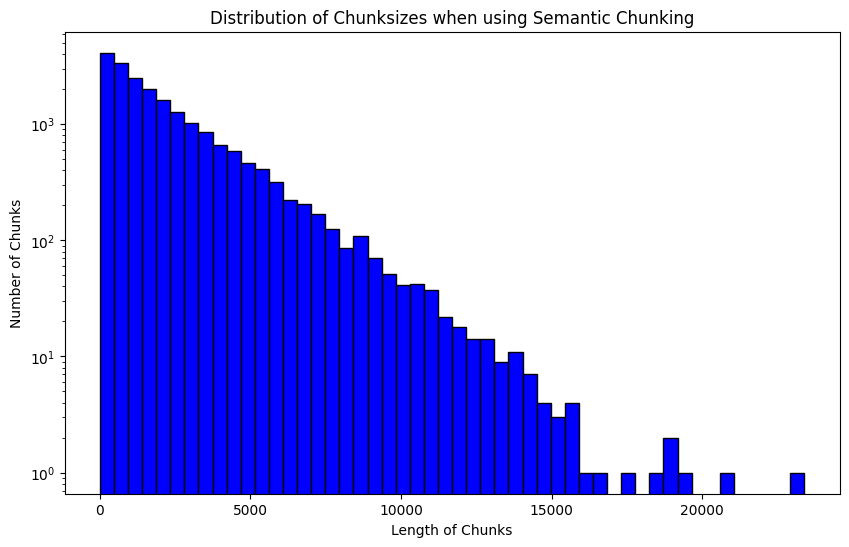

In [25]:
import matplotlib.pyplot as plt

num_chunks = len(df)
print("Number of Chunks", num_chunks)

chunk_lengths = [len(text) for text in df['documents']]
print("Lengths of Chunks", chunk_lengths)

plt.figure(figsize=(10, 6))  
plt.hist(chunk_lengths, bins=50, color='blue', edgecolor='black')
plt.yscale('log')

plt.title('Distribution of Chunksizes when using Semantic Chunking')
plt.xlabel('Length of Chunks')
plt.ylabel('Number of Chunks')

plt.show()

#### Evaluation with GPT-3.5-turbo

In [2]:
import os
os.chdir('../')

In [5]:
from rag import Rag
from evaluator import RagEvaluator

semantic_rag = Rag(chunkingstrategy='percentile', llm='gpt-3.5-turbo-0125', embedding='text-embedding-3-small')
semantic_rag_eval = RagEvaluator(rag=semantic_rag, eval_llm='gpt-3.5-turbo-0125', embedding_function='text-embedding-3-small')

result = semantic_rag_eval.get_mean_result()
print(result)

passing column names as 'ground_truths' is deprecated and will be removed in the next version, please use 'ground_truth' instead. Note that `ground_truth` should be of type string and not Sequence[string] like `ground_truths`
Evaluating: 100%|██████████| 72/72 [02:36<00:00,  2.17s/it]
passing column names as 'ground_truths' is deprecated and will be removed in the next version, please use 'ground_truth' instead. Note that `ground_truth` should be of type string and not Sequence[string] like `ground_truths`
Evaluating:  75%|███████▌  | 54/72 [02:09<00:33,  1.86s/it]Task exception was never retrieved
future: <Task finished name='Task-2906' coro=<AsyncClient.aclose() done, defined at /home/dabr/code/langchain-rag-eval/venv/lib/python3.10/site-packages/httpx/_client.py:2011> exception=RuntimeError('Event loop is closed')>
Traceback (most recent call last):
  File "/home/dabr/code/langchain-rag-eval/venv/lib/python3.10/site-packages/httpx/_client.py", line 2018, in aclose
    await self._tr

{'answer_relevancy': 0.3697, 'answer_correctness': 0.2596, 'context_recall': 0.3365, 'context_relevancy': 0.0189}


**Evaluation result**

{'answer_relevancy': 0.3697, 'answer_correctness': 0.2596, 'context_recall': 0.3365, 'context_relevancy': 0.0189}

#### Evaluation with GPT-4o

In [4]:
semantic_rag = Rag(chunkingstrategy='percentile', llm='gpt-3.5-turbo-0125', embedding='text-embedding-3-small')
semantic_rag_eval = RagEvaluator(rag=semantic_rag, eval_llm='gpt-4o', embedding_function='text-embedding-3-small')

result = semantic_rag_eval.get_mean_result()
print(result)

passing column names as 'ground_truths' is deprecated and will be removed in the next version, please use 'ground_truth' instead. Note that `ground_truth` should be of type string and not Sequence[string] like `ground_truths`
Evaluating:  69%|██████▉   | 50/72 [03:12<01:07,  3.07s/it]Runner in Executor raised an exception
Traceback (most recent call last):
  File "/home/dabr/code/langchain-rag-eval/venv/lib/python3.10/site-packages/ragas/executor.py", line 79, in _aresults
    r = await future
  File "/usr/lib/python3.10/asyncio/tasks.py", line 571, in _wait_for_one
    return f.result()  # May raise f.exception().
  File "/home/dabr/code/langchain-rag-eval/venv/lib/python3.10/site-packages/ragas/executor.py", line 38, in sema_coro
    return await coro
  File "/home/dabr/code/langchain-rag-eval/venv/lib/python3.10/site-packages/ragas/executor.py", line 112, in wrapped_callable_async
    return counter, await callable(*args, **kwargs)
  File "/home/dabr/code/langchain-rag-eval/venv/lib

{'answer_relevancy': 0.3867, 'answer_correctness': 0.3006, 'context_recall': 0.1931, 'context_relevancy': 0.135}


**Evaluation Result**

{'answer_relevancy': 0.3867, 'answer_correctness': 0.3006, 'context_recall': 0.1931, 'context_relevancy': 0.135}